In [24]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from utils import A_cluster
from tqdm.auto import tqdm


In [25]:
class config:
    input = 28*28
    output = 20
    hid = 256    # RC Neurons
    thr = 0.5
    decay = 0.5
    rst = 0.05
    
    N_hid = hid
    p_in = 0.2        # ratio of inhibitory neurons
    gamma = 1.0       # shape factor of gamma distribution
    binary = False    # binary matrix of reservoir A
    net_type = 'BAC'  # type of reservoir connection topology
                      # 'ER',  # Erdos-Renyi Random Network
                      # 'ERC', # Clusters of Erdos-Renyi Networks
                      # 'BA',  # Barabasi-Albert Network
                      # 'BAC', # Clusters of Barabasi-Albert networks
                      # 'WS',  # Watts Strogatz small world networks
                      # 'WSC', # Clusters of Watts Strogatz small world networks
                      # 'RAN', # random network
                      # 'DTW', # Developmental Time Window for multi-cluster small-world network
    noise = True      # add noise in A
    noise_str = 0.05  # noise strength
    p_ER = 0.2        # connection probability when creating edges, for ER and WS graphs
    m_BA = 3          # number of edges to attach from a new node to existing nodes
    k = 5             # number of clusters in A
    R = 0.2           # distance factor when deciding connections in random network
    scale = False     # rescale matrix A with spectral radius
    
    
    batch = 128
    epoch = 100
    lr = 0.01
    device = torch.device('cuda:0')
    

In [26]:
from spikingjelly.datasets.shd import SpikingHeidelbergDigits
from spikingjelly.datasets.n_mnist import NMNIST

nmnist_train = NMNIST('D:\Ph.D\Research\SNN-SRT数据/N-MNIST', train=True, data_type='frame', frames_number=20, split_by='number')
nmnist_test = NMNIST('D:\Ph.D\Research\SNN-SRT数据/N-MNIST', train=False, data_type='frame', frames_number=20, split_by='number')
train_loader = torch.utils.data.DataLoader(dataset=nmnist_train, batch_size=config.batch, shuffle=True, drop_last=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=nmnist_test, batch_size=config.batch, shuffle=False, drop_last=False, num_workers=0)

# SHD_train = SpikingHeidelbergDigits('D:\Ph.D\Research\SNN-SRT数据\SHD', train=True, data_type='frame', frames_number=20, split_by='number')
# SHD_test = SpikingHeidelbergDigits('D:\Ph.D\Research\SNN-SRT数据\SHD', train=False, data_type='frame', frames_number=20, split_by='number')
# train_loader = torch.utils.data.DataLoader(dataset=SHD_train, batch_size=config.batch, shuffle=True, drop_last=False, num_workers=0)
# test_loader = torch.utils.data.DataLoader(dataset=SHD_test, batch_size=config.batch, shuffle=False, drop_last=False, num_workers=0)

The directory [D:\Ph.D\Research\SNN-SRT数据/N-MNIST\frames_number_20_split_by_number] already exists.
The directory [D:\Ph.D\Research\SNN-SRT数据/N-MNIST\frames_number_20_split_by_number] already exists.


In [27]:
class ActFun(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.gt(0).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        temp = abs(input - 0) < 0.5 # lens
        return grad_input * temp.float()

act_fun = ActFun.apply

In [28]:
def mem_update(input, mem, spk, thr, decay, rst):
    mem = rst * spk + mem * decay * (1-spk) + input
    spike = act_fun(mem - thr)
    return mem, spike

class RC(nn.Module):
    def __init__(self) -> None:
        super(RC, self).__init__()
        input = config.input
        hid = config.hid
        out = config.output
        self.fc_in = nn.Linear(input, hid)
        self.conv_in = nn.Sequential(
                                nn.Conv2d(2, 16, 3),
                                nn.ReLU(),
                                nn.AvgPool2d(2, 2),
                                nn.Conv2d(16, 16, 3),
                                nn.ReLU(),
                                nn.AvgPool2d(2, 2),
                                nn.Flatten(),
                                self.fc_in,
        )
        self.conv_in.requires_grad_ = False
        
        self.A = nn.Parameter(torch.tensor(A_cluster(config)), requires_grad=False) # 邻接矩阵
        self.fc_out = nn.Linear(hid, out)
        
    def forward(self, input):
        batch, time_step = input.shape[0:2]
        
        hid_mem = torch.empty(batch, config.hid).uniform_(0, 0.1).to('cuda')
        hid_spk = sum_spk = torch.zeros(batch, config.hid).to('cuda')
        for t in range(time_step):
            # x = self.fc_in(input[:,t,:])
            x = self.conv_in(input[:, t, :, :, :])
            # print(x.shape)
            x = x @ self.A
            hid_mem, hid_spk = mem_update(x, hid_mem, hid_spk, config.thr, config.decay, config.rst)
            sum_spk += hid_spk
        sum_spk /= time_step
        out = self.fc_out(sum_spk)
        return out


In [29]:
def train(model, optimizer, criterion, num_epochs, train_loader, test_loader, device):
    train_accs, test_accs = [], []
    for epoch in range(num_epochs):
        now = time.time()
        for i, (samples, labels) in enumerate(tqdm(train_loader)):
            # samples = samples.requires_grad_().to(device)
            labels = labels.long().to(device)
            optimizer.zero_grad()
            outputs = model(samples.to(device))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        tr_acc = test(model, train_loader)
        ts_acc = test(model, test_loader)
        train_accs.append(tr_acc)
        test_accs.append(ts_acc)
        res_str = 'epoch: ' + str(epoch) \
                    + ' Loss: ' + str(loss.item()) \
                    + '. Tr Acc: ' + str(tr_acc)   \
                    + '. Ts Acc: ' + str(ts_acc)   \
                    + '. Time:' + str(time.time()-now)
        print(res_str)
    return train_accs, ts_acc

def test(model, dataloader):
    correct, total = 0, 0
    for images, labels in dataloader:
        outputs = model(images.to(config.device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.long().cpu()).sum()
    accuracy = 100. * correct.numpy() / total
    return accuracy

In [34]:
256*256-(model.A!=0).sum()

tensor(51128, device='cuda:0')

In [30]:
model = RC().to('cuda')
for name, p in model.named_parameters():
    if 'conv' in name or 'fc_in' in name:
        p.requires_grad = False
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.lr)
acc = train(model, optimizer, criterion, config.epoch, train_loader, test_loader, 'cuda')
accuracy = test(model, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 0 Loss: 1.1170083284378052. Tr Acc: 72.58833333333334. Ts Acc: 75.17. Time:1162.582263469696


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1 Loss: 0.8418045043945312. Tr Acc: 76.59666666666666. Ts Acc: 78.76. Time:308.80906534194946


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2 Loss: 0.8813906311988831. Tr Acc: 78.85833333333333. Ts Acc: 80.78. Time:306.6517586708069


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3 Loss: 0.8206872940063477. Tr Acc: 79.89666666666666. Ts Acc: 81.22. Time:327.1986074447632


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4 Loss: 0.6347170472145081. Tr Acc: 80.54166666666667. Ts Acc: 81.9. Time:295.7764344215393


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5 Loss: 0.6210606694221497. Tr Acc: 80.86333333333333. Ts Acc: 82.15. Time:286.65477681159973


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6 Loss: 0.47522690892219543. Tr Acc: 81.43833333333333. Ts Acc: 82.68. Time:289.93672347068787


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7 Loss: 0.5338914394378662. Tr Acc: 81.68666666666667. Ts Acc: 82.75. Time:281.72407960891724


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8 Loss: 0.8341158032417297. Tr Acc: 81.90166666666667. Ts Acc: 82.92. Time:282.47384572029114


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9 Loss: 0.6238268613815308. Tr Acc: 82.04666666666667. Ts Acc: 82.93. Time:300.18015217781067


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10 Loss: 0.5580610036849976. Tr Acc: 82.13. Ts Acc: 83.17. Time:250.66649889945984


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 11 Loss: 0.6030929684638977. Tr Acc: 82.27166666666666. Ts Acc: 83.28. Time:272.4943871498108


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 12 Loss: 0.6630339026451111. Tr Acc: 82.35833333333333. Ts Acc: 83.05. Time:265.1927285194397


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 13 Loss: 0.5197514295578003. Tr Acc: 82.54833333333333. Ts Acc: 83.42. Time:238.84360265731812


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 14 Loss: 0.5205071568489075. Tr Acc: 82.57333333333334. Ts Acc: 83.43. Time:235.48883032798767


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 15 Loss: 0.5613263845443726. Tr Acc: 82.68833333333333. Ts Acc: 83.59. Time:230.3312168121338


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 16 Loss: 0.6519025564193726. Tr Acc: 82.81166666666667. Ts Acc: 83.46. Time:230.7472198009491


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 17 Loss: 0.6249439716339111. Tr Acc: 82.83. Ts Acc: 83.76. Time:230.3309714794159


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 18 Loss: 0.4739638566970825. Tr Acc: 82.77166666666666. Ts Acc: 83.61. Time:233.15223217010498


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 19 Loss: 0.4390448331832886. Tr Acc: 82.97833333333334. Ts Acc: 83.59. Time:233.14792609214783


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 20 Loss: 0.5073492527008057. Tr Acc: 82.84333333333333. Ts Acc: 83.63. Time:232.9994306564331


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 21 Loss: 0.5605764389038086. Tr Acc: 82.90833333333333. Ts Acc: 83.55. Time:234.39812874794006


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 22 Loss: 0.6162800192832947. Tr Acc: 82.915. Ts Acc: 83.85. Time:234.40913653373718


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 23 Loss: 0.5515264272689819. Tr Acc: 83.065. Ts Acc: 83.78. Time:233.98141813278198


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 24 Loss: 0.6560088992118835. Tr Acc: 82.995. Ts Acc: 83.86. Time:234.5746967792511


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 25 Loss: 0.6780104637145996. Tr Acc: 83.02666666666667. Ts Acc: 83.58. Time:236.5411548614502


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 26 Loss: 0.4494004547595978. Tr Acc: 82.885. Ts Acc: 83.57. Time:237.0990972518921


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 27 Loss: 0.450696736574173. Tr Acc: 82.985. Ts Acc: 83.76. Time:237.7766592502594


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 28 Loss: 0.4803667962551117. Tr Acc: 83.17166666666667. Ts Acc: 83.71. Time:236.9782199859619


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 29 Loss: 0.48504117131233215. Tr Acc: 83.11333333333333. Ts Acc: 83.98. Time:233.81302547454834


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 30 Loss: 0.5865359306335449. Tr Acc: 83.075. Ts Acc: 83.54. Time:233.3759844303131


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 31 Loss: 0.45261645317077637. Tr Acc: 83.11666666666666. Ts Acc: 83.76. Time:233.41712474822998


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 32 Loss: 0.4153755009174347. Tr Acc: 83.21. Ts Acc: 83.94. Time:234.3227424621582


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 33 Loss: 0.5639399290084839. Tr Acc: 83.195. Ts Acc: 83.94. Time:234.3585398197174


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 34 Loss: 0.35161128640174866. Tr Acc: 83.19333333333333. Ts Acc: 83.92. Time:231.31100153923035


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 35 Loss: 0.4788248538970947. Tr Acc: 83.06666666666666. Ts Acc: 83.79. Time:231.50284433364868


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 36 Loss: 0.4766896665096283. Tr Acc: 83.135. Ts Acc: 83.66. Time:228.29360270500183


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 37 Loss: 0.41877874732017517. Tr Acc: 83.24. Ts Acc: 83.89. Time:228.01704668998718


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 38 Loss: 0.5128807425498962. Tr Acc: 83.175. Ts Acc: 83.89. Time:228.8131902217865


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 39 Loss: 0.41873976588249207. Tr Acc: 83.24. Ts Acc: 83.84. Time:228.29257225990295


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 40 Loss: 0.456741601228714. Tr Acc: 83.19166666666666. Ts Acc: 83.73. Time:230.71941375732422


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 41 Loss: 0.6243852972984314. Tr Acc: 83.35333333333334. Ts Acc: 83.77. Time:238.90625166893005


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 42 Loss: 0.4149629771709442. Tr Acc: 83.26333333333334. Ts Acc: 83.89. Time:233.14822673797607


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 43 Loss: 0.3748762607574463. Tr Acc: 83.185. Ts Acc: 83.85. Time:233.38052463531494


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 44 Loss: 0.6112664341926575. Tr Acc: 83.20833333333333. Ts Acc: 83.96. Time:232.0472400188446


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 45 Loss: 0.41804108023643494. Tr Acc: 83.30166666666666. Ts Acc: 84.02. Time:229.73060941696167


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 46 Loss: 0.582581639289856. Tr Acc: 83.28666666666666. Ts Acc: 83.94. Time:230.1726529598236


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 47 Loss: 0.49858033657073975. Tr Acc: 83.14333333333333. Ts Acc: 83.85. Time:229.79026460647583


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 48 Loss: 0.5767838954925537. Tr Acc: 83.27333333333333. Ts Acc: 83.85. Time:230.10466861724854


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 49 Loss: 0.6782751083374023. Tr Acc: 83.16666666666667. Ts Acc: 83.53. Time:228.55019998550415


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 50 Loss: 0.7603016495704651. Tr Acc: 83.08. Ts Acc: 83.58. Time:231.07221293449402


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 51 Loss: 0.4462164640426636. Tr Acc: 83.2. Ts Acc: 83.8. Time:229.5294361114502


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 52 Loss: 0.5859620571136475. Tr Acc: 83.30166666666666. Ts Acc: 84.04. Time:231.7656853199005


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 53 Loss: 0.5209695100784302. Tr Acc: 83.31. Ts Acc: 84.0. Time:228.75887608528137


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 54 Loss: 0.6612052917480469. Tr Acc: 83.30666666666667. Ts Acc: 83.86. Time:227.49308729171753


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 55 Loss: 0.5234086513519287. Tr Acc: 83.145. Ts Acc: 83.95. Time:229.25930881500244


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 56 Loss: 0.5204037427902222. Tr Acc: 83.24166666666666. Ts Acc: 83.96. Time:228.83314728736877


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 57 Loss: 0.592095673084259. Tr Acc: 83.30833333333334. Ts Acc: 84.1. Time:232.44748759269714


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 58 Loss: 0.41659286618232727. Tr Acc: 83.19833333333334. Ts Acc: 83.94. Time:233.1551651954651


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 59 Loss: 0.3984718322753906. Tr Acc: 83.27333333333333. Ts Acc: 83.93. Time:232.6807873249054


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 60 Loss: 0.5004477500915527. Tr Acc: 83.22166666666666. Ts Acc: 83.65. Time:230.85571932792664


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 61 Loss: 0.48636528849601746. Tr Acc: 83.275. Ts Acc: 83.86. Time:229.19271755218506


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 62 Loss: 0.5669487118721008. Tr Acc: 83.29666666666667. Ts Acc: 84.0. Time:229.6380934715271


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 63 Loss: 0.5279586315155029. Tr Acc: 83.32833333333333. Ts Acc: 83.94. Time:230.44518971443176


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 64 Loss: 0.29716911911964417. Tr Acc: 83.20833333333333. Ts Acc: 83.92. Time:230.80272436141968


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 65 Loss: 0.5329641699790955. Tr Acc: 83.27333333333333. Ts Acc: 84.12. Time:230.35189652442932


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 66 Loss: 0.46664464473724365. Tr Acc: 83.25166666666667. Ts Acc: 83.95. Time:229.20670080184937


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 67 Loss: 0.4296388626098633. Tr Acc: 83.31. Ts Acc: 83.67. Time:231.05131912231445


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 68 Loss: 0.5264003872871399. Tr Acc: 83.35. Ts Acc: 83.83. Time:231.07621669769287


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 69 Loss: 0.5258633494377136. Tr Acc: 83.425. Ts Acc: 83.96. Time:230.5658175945282


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 70 Loss: 0.43803754448890686. Tr Acc: 83.28. Ts Acc: 83.89. Time:229.02899503707886


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 71 Loss: 0.40380123257637024. Tr Acc: 83.20166666666667. Ts Acc: 83.79. Time:230.1404366493225


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 72 Loss: 0.4477955400943756. Tr Acc: 83.29666666666667. Ts Acc: 83.89. Time:229.87168192863464


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 73 Loss: 0.42652761936187744. Tr Acc: 83.385. Ts Acc: 83.93. Time:233.47296285629272


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 74 Loss: 0.7567169666290283. Tr Acc: 83.28166666666667. Ts Acc: 83.85. Time:232.42372465133667


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 75 Loss: 0.5580694079399109. Tr Acc: 83.305. Ts Acc: 83.9. Time:232.7897653579712


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 76 Loss: 0.5778729319572449. Tr Acc: 83.3. Ts Acc: 83.92. Time:228.71280908584595


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 77 Loss: 0.4322773516178131. Tr Acc: 83.19. Ts Acc: 83.99. Time:229.37793898582458


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 78 Loss: 0.5463284850120544. Tr Acc: 83.355. Ts Acc: 83.89. Time:227.1679208278656


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 79 Loss: 0.5633904337882996. Tr Acc: 83.25333333333333. Ts Acc: 83.76. Time:228.26789927482605


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 80 Loss: 0.5787233114242554. Tr Acc: 83.27. Ts Acc: 83.97. Time:227.29905200004578


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 81 Loss: 0.5959587693214417. Tr Acc: 83.33666666666667. Ts Acc: 84.04. Time:228.48568415641785


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 82 Loss: 0.8834033608436584. Tr Acc: 83.30833333333334. Ts Acc: 83.87. Time:229.50415897369385


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 83 Loss: 0.5581173896789551. Tr Acc: 83.4. Ts Acc: 83.91. Time:230.11496496200562


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 84 Loss: 0.5355076193809509. Tr Acc: 83.425. Ts Acc: 84.15. Time:230.12854504585266


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 85 Loss: 0.4418462812900543. Tr Acc: 83.455. Ts Acc: 83.97. Time:229.62336421012878


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 86 Loss: 0.6029171943664551. Tr Acc: 83.38333333333334. Ts Acc: 84.06. Time:230.38990259170532


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 87 Loss: 0.5686477422714233. Tr Acc: 83.40833333333333. Ts Acc: 84.0. Time:229.93418979644775


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 88 Loss: 0.5896912813186646. Tr Acc: 83.32. Ts Acc: 84.03. Time:232.50153756141663


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 89 Loss: 0.473122239112854. Tr Acc: 83.37. Ts Acc: 84.02. Time:233.13329648971558


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 90 Loss: 0.6175448298454285. Tr Acc: 83.29166666666667. Ts Acc: 83.87. Time:233.982816696167


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 91 Loss: 0.4750451147556305. Tr Acc: 83.295. Ts Acc: 83.93. Time:232.94291853904724


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 92 Loss: 0.5886226296424866. Tr Acc: 83.39. Ts Acc: 83.93. Time:232.5171525478363


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 93 Loss: 0.6785008907318115. Tr Acc: 83.26166666666667. Ts Acc: 84.06. Time:233.17739176750183


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 94 Loss: 0.5321668982505798. Tr Acc: 83.24166666666666. Ts Acc: 83.83. Time:229.23889756202698


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 95 Loss: 0.551856279373169. Tr Acc: 83.34666666666666. Ts Acc: 84.1. Time:226.9203906059265


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 96 Loss: 0.5449196100234985. Tr Acc: 83.35666666666667. Ts Acc: 83.96. Time:228.70362424850464


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 97 Loss: 0.2975296974182129. Tr Acc: 83.36333333333333. Ts Acc: 83.98. Time:227.76629829406738


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 98 Loss: 0.5131909251213074. Tr Acc: 83.38. Ts Acc: 83.96. Time:228.29850554466248


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 99 Loss: 0.3921109437942505. Tr Acc: 83.35666666666667. Ts Acc: 83.96. Time:229.5439648628235


In [23]:
model = RC().to('cuda')
# model.conv_in.requires_grad_ = False
for name, p in model.named_parameters():
    if 'conv' in name or 'fc_in' in name:
        p.requires_grad = False
        # print(name, p.shape)
    # if p.requires_grad is False:
    #     print(p.shape)
params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print("Parameters: {:.2f}K".format(params / 1e3))

Parameters: 5.14K


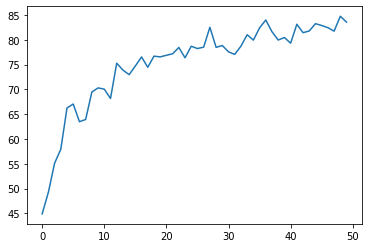

In [57]:
plt.plot(acc)

In [6]:
from thop import profile

model = RC().to('cuda')
model.conv_in.requires_grad_ = False
params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print("Parameters: {:.2f}K".format(params / 1e3))

input = torch.randn(1, 20, 2, 34, 34).cuda() #.to(config.device)
flops, params = profile(model.cuda(), inputs=(input,))
print("FLOPS: {:.2f}M".format(flops / 1e6))
print("Parameters: {:.2f}K".format(params / 1e3))

Parameters: 208.72K
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
FLOPS: 31.09M
Parameters: 409.68K
